# 05 - Predictive Modelling

In [1]:
# Import libraries and packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, RandomizedSearchCV, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import make_scorer, average_precision_score, precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree
from sklearn.model_selection import PredefinedSplit
import pickle
from sklearn.ensemble import StackingClassifier
from lightgbm import LGBMClassifier
from scipy.stats import randint, uniform
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
# Read in Data
df = pd.read_csv(r"/Users/emmanuel/Documents/Portfolio Projects/FA_Player_Development_Model/data/processed/Feature_Engineered.csv").drop(['Unnamed: 0'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 73 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   player_key_or_id        22 non-null     object 
 1   Player                  22 non-null     object 
 2   season                  22 non-null     object 
 3   Primary_Squad           22 non-null     object 
 4   Playing Time_Min        22 non-null     int64  
 5   gls_per90               22 non-null     float64
 6   ast_per90               22 non-null     float64
 7   xg_per90                22 non-null     float64
 8   xag_per90               22 non-null     float64
 9   npxg_per90              22 non-null     float64
 10  prgC_per90              22 non-null     float64
 11  prgP_per90              22 non-null     float64
 12  prgR_per90              22 non-null     float64
 13  gls_per90_t1            22 non-null     float64
 14  gls_per90_t2            22 non-null     floa

## Feature Selection

In [3]:
corr_matrix = df[['Playing Time_Min', 'gls_per90', 'ast_per90', 'xg_per90', 'xag_per90', 'npxg_per90',
                     'prgC_per90', 'prgP_per90', 'prgR_per90', 'team_strength_curr', 'team_gf_curr',
                     'team_ga_curr', 'team_pts_curr', 'gls_per90_roll3', 'ast_per90_roll3', 'xg_per90_roll3', 
                     'xag_per90_roll3', 'npxg_per90_roll3', 'prgC_per90_roll3', 'prgP_per90_roll3', 'prgR_per90_roll3']].corr()

Text(0.5, 1.0, 'Correlation Matrix of Goal Contribution & Progressive Variables')

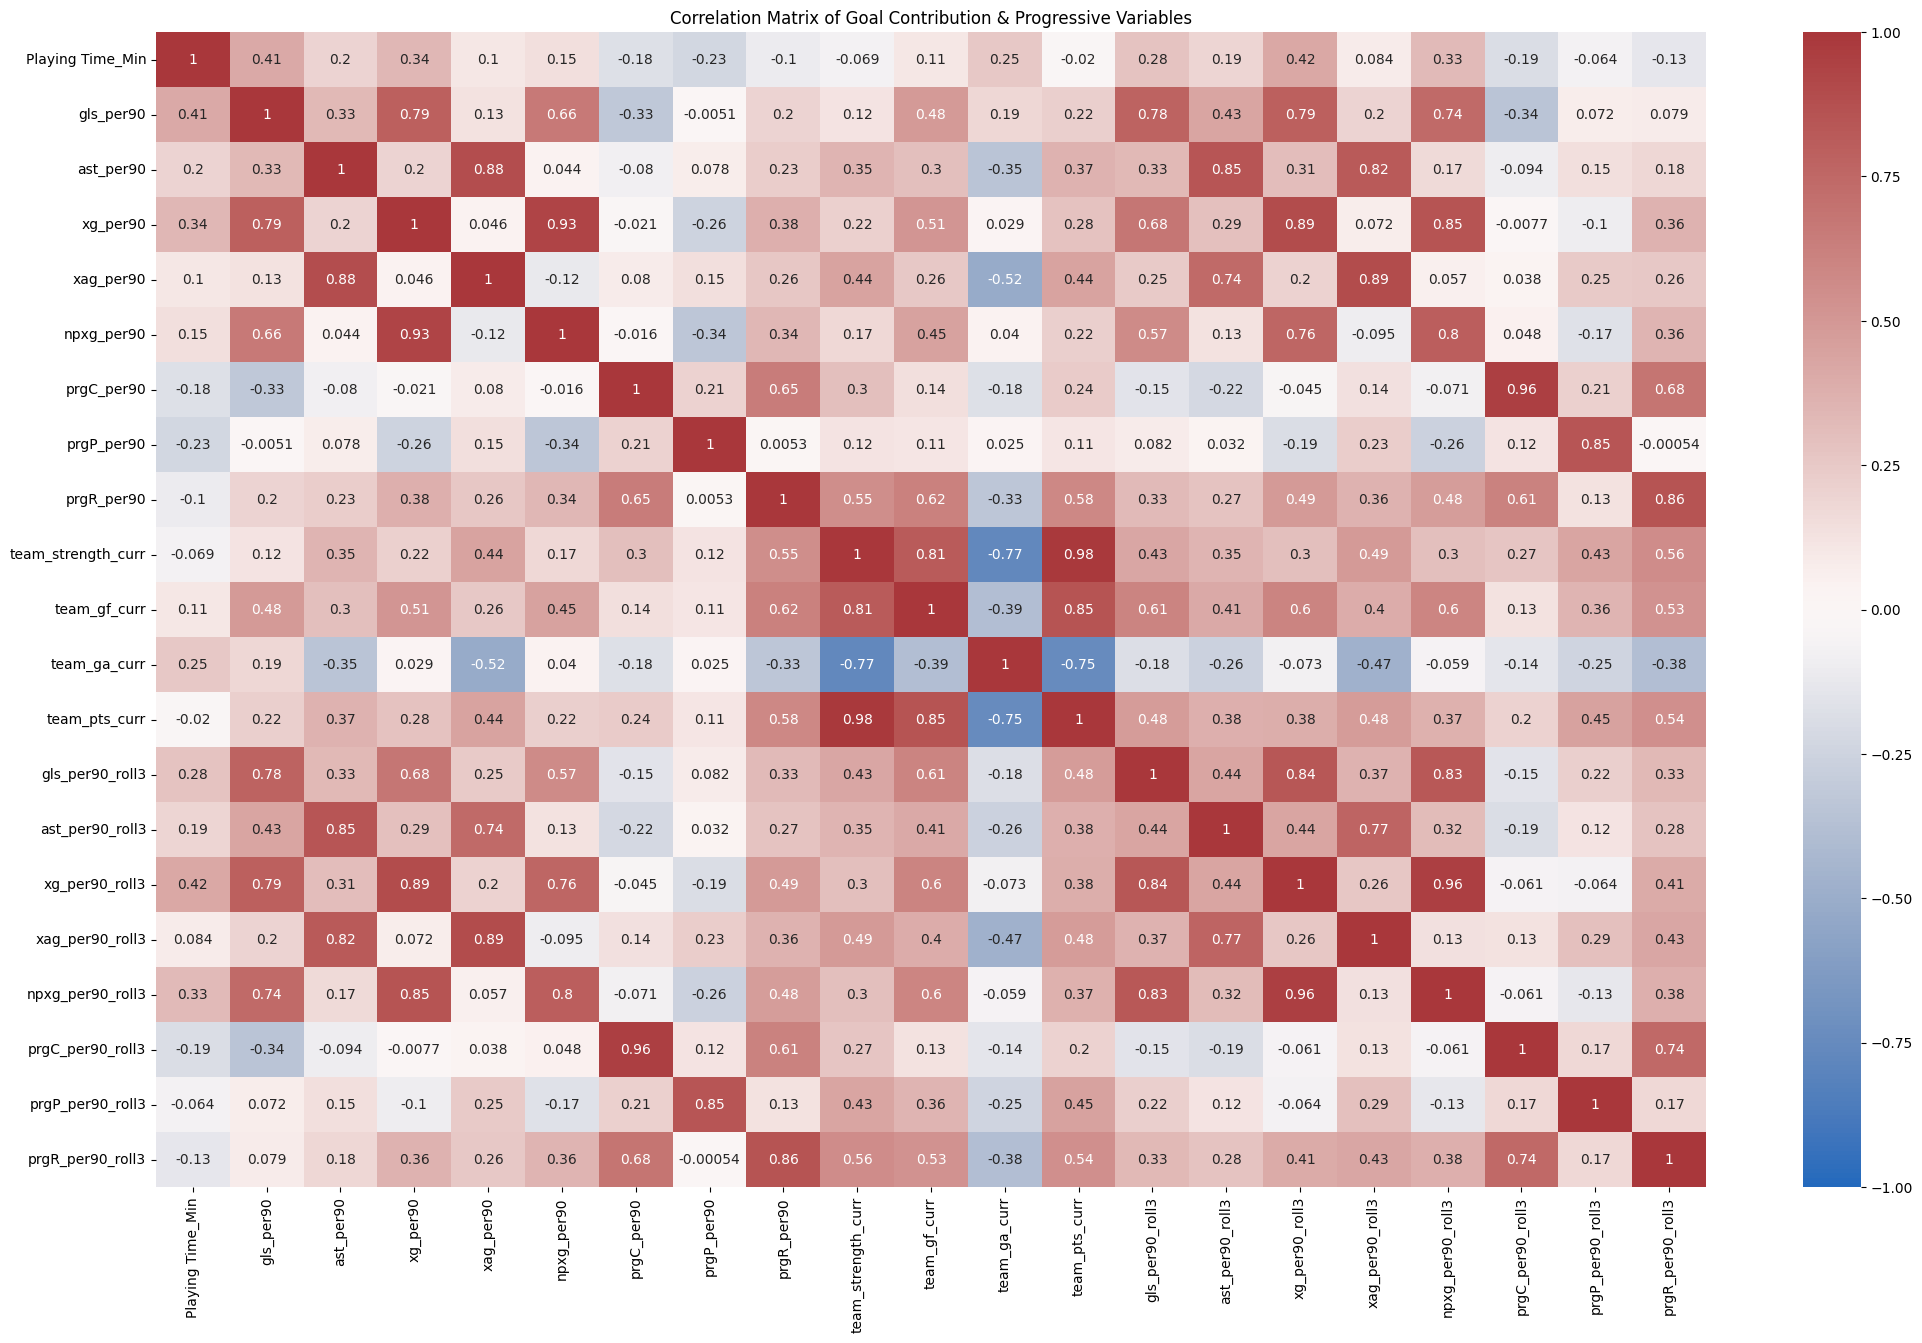

In [4]:
# Heatmap
plt.figure(figsize=(25, 15))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
plt.title("Correlation Matrix of Goal Contribution & Progressive Variables")

In [5]:
# Selected Features 

corr_matrix = df[['xg_per90', 'xag_per90', 'xg_per90_t1', 'xag_per90_t1', 'Playing Time_Min_t1', 'ast_per90_t1',
                     'prgC_per90_t1', 'prgP_per90_t1', 'prgR_per90_t1', 'team_strength_t1']].corr()

Text(0.5, 1.0, 'Correlation Matrix of Goal Contribution & Progressive Variables')

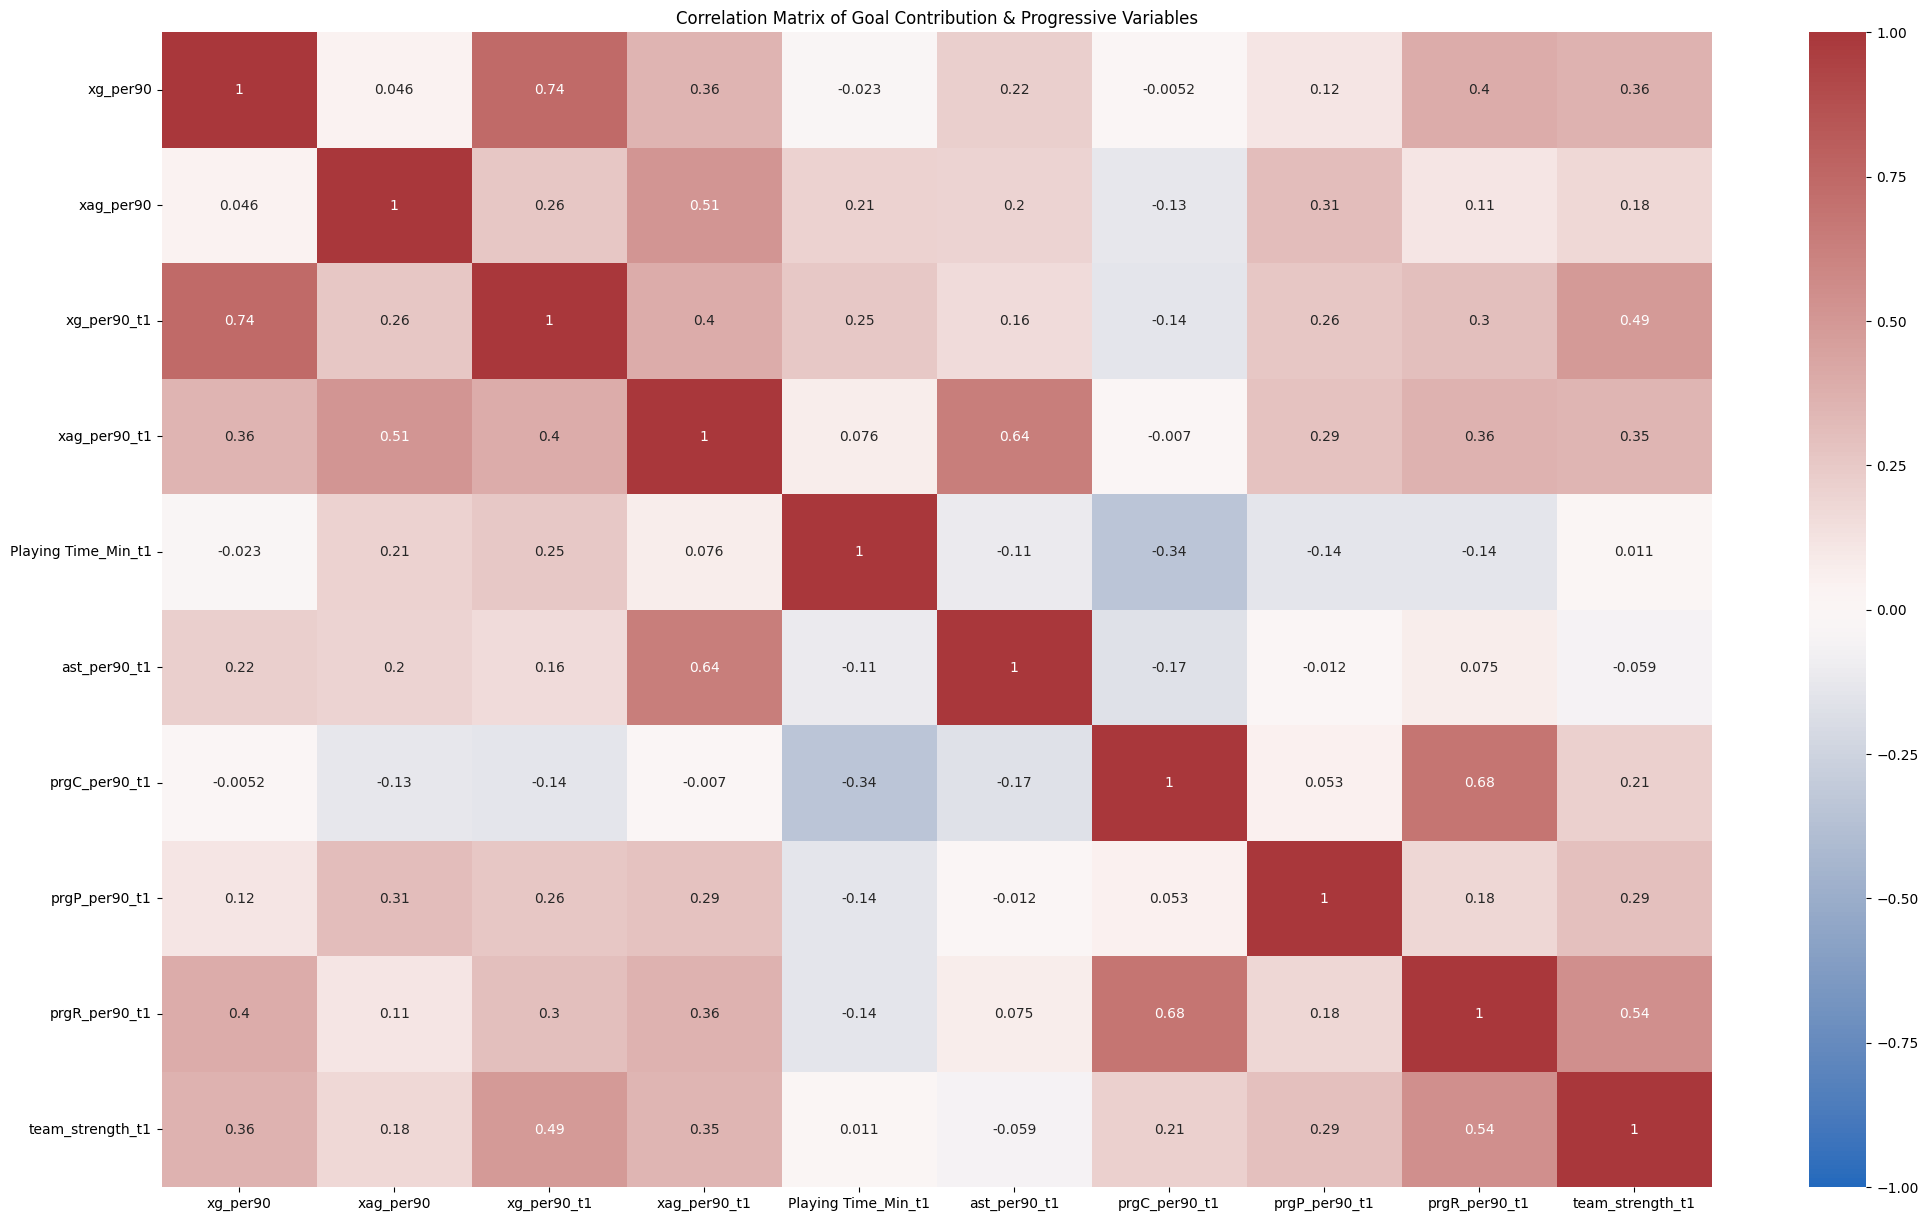

In [6]:
# Heatmap
plt.figure(figsize=(25, 15))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
plt.title("Correlation Matrix of Goal Contribution & Progressive Variables")

**Correlation Analysis**

A correlation matrix was computed among goal contribution, expected metrics, and progression features to identify redundancy.

Key findings:
- Strong correlations were observed between gls_per90_t1 and xg_per90_t1 (r ≈ 0.75) and between ast_per90_t1 and xag_per90_t1 (r ≈ 0.64).
> These reflect outcome vs underlying process; xg/xag are preferred for stability.
- Progression variables (prgC_per90_t1, prgP_per90_t1, prgR_per90_t1) were moderately correlated (0.5–0.7), capturing related but distinct aspects of ball progression.
- Team strength and playing time showed modest correlations with performance metrics, so both were retained as contextual features.

To mitigate multicollinearity, features with correlation coefficients above 0.9 were removed, while complementary features below that threshold were retained.

## Modelling

In [7]:
# Keep player info for reference 
id_cols = ["player_key_or_id", "Player"]

# Predictor Features
predictor_features = [
    "xg_per90_t1",
    "xag_per90_t1",
    "ast_per90_t1",
    "prgC_per90_t1",
    "prgP_per90_t1",
    "prgR_per90_t1",
    "team_strength_t1",
    "Playing Time_Min_t1"
]

# Target prediction
df["target_xgxa_per90"] = df["xg_per90"] + df["xag_per90"]

# Model Dataframe
model_df = df[id_cols + predictor_features + ["target_xgxa_per90"]]

In [8]:
# Separate features and target for model training
X = model_df[predictor_features]
y = model_df["target_xgxa_per90"]

### Baseline Model

In [9]:
X_train, X_test, y_train, y_test, meta_train, meta_test = train_test_split(X, y, model_df[id_cols], test_size=0.25, random_state=42)

# Linear Regression
linreg = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])

linreg.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('lr', LinearRegression())])

In [10]:
# Predictions 
y_pred = linreg.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"Linear Regression (baseline)")
print(f"MAE : {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R²  : {r2:.4f}")


Linear Regression (baseline)
MAE : 0.1122
MSE: 0.0153
R²  : 0.2739


- **MAE**: On average, predictions are off by 0.11 xG+xAG per90
- **MSE**: Reflects moderate error, consistent with the MAE
- **R²**: The model explains roughly 27% of the variance in next-season attacking output.

The linear regression captures some relationship between last season’s attacking and progression metrics and next-season expected output, but much variance remains unexplained

In [11]:
# 4) Predictions per player on test set
results = meta_test.copy()
results["y_true"] = y_test.values
results["y_pred"] = y_pred
results["error"]  = results["y_pred"] - results["y_true"]
results = results.sort_values("y_pred", ascending=False)
display(results)

,player_key_or_id,Player,y_true,y_pred,error
5,3ea50f67,Harvey Barnes,0.574359,0.793398,0.219039
0,0cd31129,Brennan Johnson,0.525034,0.631674,0.106640
15,bc7dc64d,Bukayo Saka,0.749566,0.631583,-0.117984
1,1971591f,Cody Gakpo,0.534884,0.589625,0.054741
8,6ca5ec4b,Alex Iwobi,0.353237,0.443240,0.090003
13,aa849a12,Jack Harrison,0.312139,0.396919,0.084780


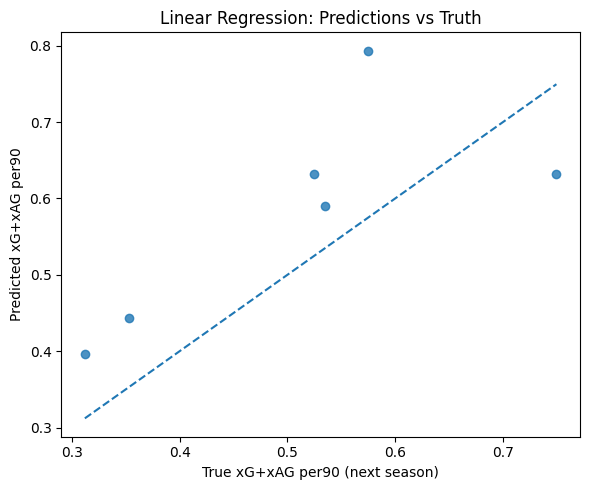

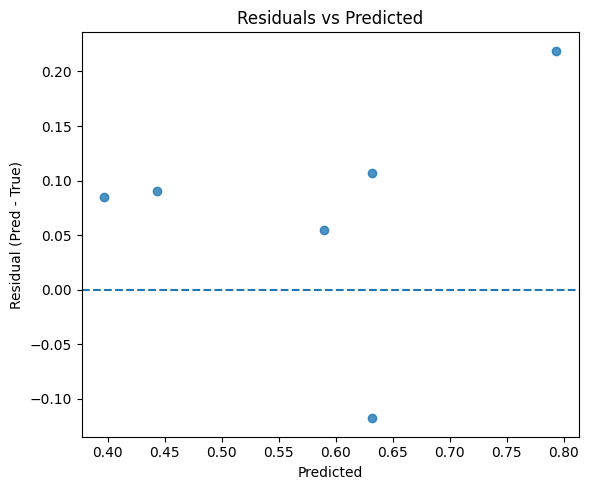

In [12]:
# Residual Charts
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred, alpha=0.8)
plt.xlabel("True xG+xAG per90 (next season)")
plt.ylabel("Predicted xG+xAG per90")
plt.title("Linear Regression: Predictions vs Truth")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle="--")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
residuals = y_pred - y_test
plt.scatter(y_pred, residuals, alpha=0.8)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residual (Pred - True)")
plt.title("Residuals vs Predicted")
plt.tight_layout()
plt.show()

**Predictions vs Truth**

Interpretation:
- The model tracks general direction (higher xG+xAG players tend to be predicted higher).
- Some under and over estimation is visible (points deviating from the diagonal).
- Indicates linear relationships capture part of the signal but may miss nonlinear patterns.

**Residual Analysis**

Interpretation:
- Residuals (Predicted – True) are centered around zero → no major systematic bias.
- Variation across predicted values suggests the model doesn’t fully generalise some players’ outcomes are overpredicted (positive residuals), others underpredicted.


### Random Forest

In [13]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# --- Hyperparameter distributions (regression) ---
param_dist = {
    "n_estimators": randint(300, 900),
    "max_depth": [None, 4, 6, 8, 10],
    "max_features": ["sqrt", "log2", None, 0.5, 0.8, 1.0],
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 5),
    "bootstrap": [True],
    "max_samples": uniform(0.8, 0.2)
}

cv = KFold(n_splits=3, shuffle=True, random_state=42)

scoring = {
    "neg_mae": make_scorer(mean_absolute_error, greater_is_better=False),
    "neg_mse": "neg_mean_squared_error",
    "r2": "r2",
}

rf_random = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=40,
    scoring=scoring,
    refit="neg_mae",           # pick the model with the best MAE
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [14]:
# Fit the model to the training data
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [None, 4, 6, 8, 10],
                                        'max_features': ['sqrt', 'log2', None,
                                                         0.5, 0.8, 1.0],
                                        'max_samples': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x17634d0...
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x174d9a0c0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17798bc80>},
                   random_state=42, refit='neg_mae',
                   scoring={'neg_mae': make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'),
                            'neg_mse': 'neg_mean_squared_error', 'r2': 'r2'},
                   verbose=1)

In [15]:
print("Best params:", rf_random.best_params_)
print("Best CV MAE:", -rf_random.best_score_)

Best params: {'bootstrap': True, 'max_depth': 8, 'max_features': None, 'max_samples': np.float64(0.873930891212281), 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 593}
Best CV MAE: 0.09237821163981623


In [16]:
best_rf = rf_random.best_estimator_

# Test evaluation
y_pred = best_rf.predict(X_test)
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print("\nRandom Forest (regression) – Test Metrics")
print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²  : {r2:.4f}")


Random Forest (regression) – Test Metrics
MAE : 0.1102
RMSE: 0.1426
R²  : 0.0328


The tuned Random Forest does not improve meaningfully over the linear baseline on the test split (baseline R² ≈ 0.27 vs RF R² ≈ 0.03).
Likely causes: very small sample size, noisy target, and CV variance. RF can overfit subtle patterns that don’t generalise with so few players.

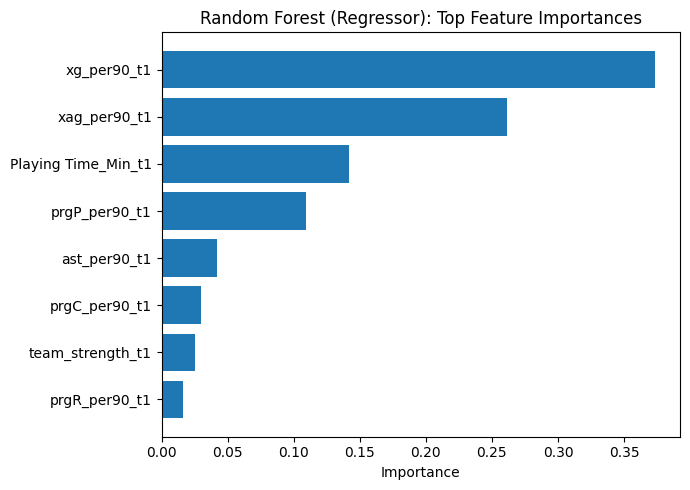

In [17]:
# --- Feature importances ---
imp = pd.DataFrame(
    {"feature": X_train.columns, "importance": best_rf.feature_importances_}
).sort_values("importance", ascending=False)

plt.figure(figsize=(7,5))
plt.barh(imp.head(10)["feature"][::-1], imp.head(10)["importance"][::-1])
plt.title("Random Forest (Regressor): Top Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

- Next-season expected output is driven most by last season’s xG and xAG (process > outcomes).
- Minutes and progressive passing add context but with lower weight.

### XGBoost

In [18]:
xgb = XGBRegressor(random_state=42,tree_method="hist", verbosity=0, objective="reg:squarederror")

# Hyperparameter
param_dist = {
    "n_estimators": [300, 500, 800],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "max_depth": [3, 4, 5, 6],
    "min_child_weight": [1, 3, 5, 7],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.2],     
    "reg_lambda": [1, 5, 10],       
    "reg_alpha": [0, 0.1, 0.5]   
}

cv = KFold(n_splits=3, shuffle=True, random_state=42)

scoring = {
    "neg_mae": make_scorer(mean_absolute_error, greater_is_better=False),
    "neg_mse": "neg_mean_squared_error",
    "r2": "r2",
}

xgb_random = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=40,
    scoring=scoring,
    refit="neg_mae", 
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

In [19]:
xgb_random.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=Non...
                                        'learning_rate': [0.01, 0.03, 0.05,
                                                          0.1],
                                        'max_depth': [3, 4, 5, 6],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'n_estimators': [300, 500, 800],
                                        'reg_alpha': [0, 0.1, 0.5],
                                        'reg_lambda': [1, 5, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, refit='neg_mae',
                   scoring={'neg_mae': make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'),
                            'neg_mse': 'neg_mean_squared_error', 'r2': 'r2'},
                   verbose=1)

In [20]:
print("Best params:", xgb_random.best_params_)
print("Best CV MAE:", -xgb_random.best_score_)

Best params: {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 500, 'min_child_weight': 7, 'max_depth': 4, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.6}
Best CV MAE: 0.09271297318351301


In [21]:
best_model = xgb_random.best_estimator_


In [22]:
# 6) Evaluate on test set
y_pred = best_model.predict(X_test)
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print("\nXGBoost (regression) – Test Metrics")
print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²  : {r2:.4f}")


XGBoost (regression) – Test Metrics
MAE : 0.1103
RMSE: 0.1429
R²  : 0.0281


- **MAE**: Avg. error of ~0.11 xG+xAG per90
- **RMSE**: Slightly higher than MAE → few larger residuals
- **R²**: Explains only ~3% of test variance

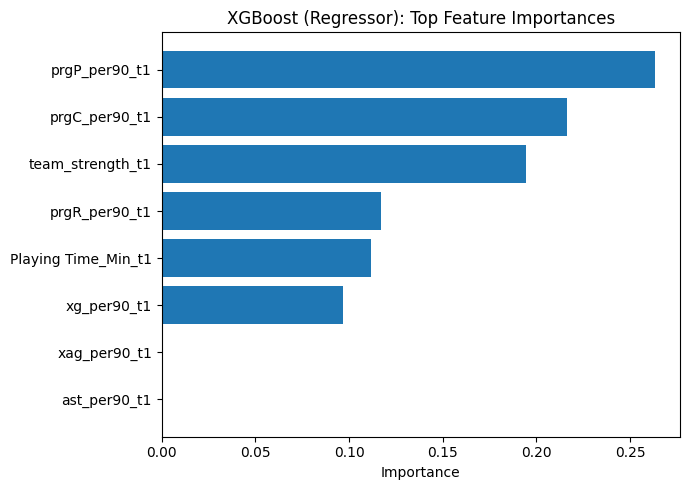

In [23]:
# Feature importance
imp = pd.DataFrame({
    "feature": X_train.columns,
    "importance": best_model.feature_importances_
}).sort_values("importance", ascending=False)

plt.figure(figsize=(7,5))
plt.barh(imp.head(10)["feature"][::-1], imp.head(10)["importance"][::-1])
plt.title("XGBoost (Regressor): Top Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

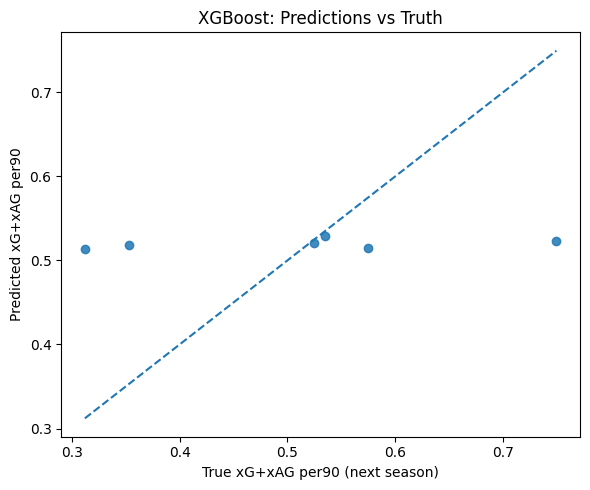

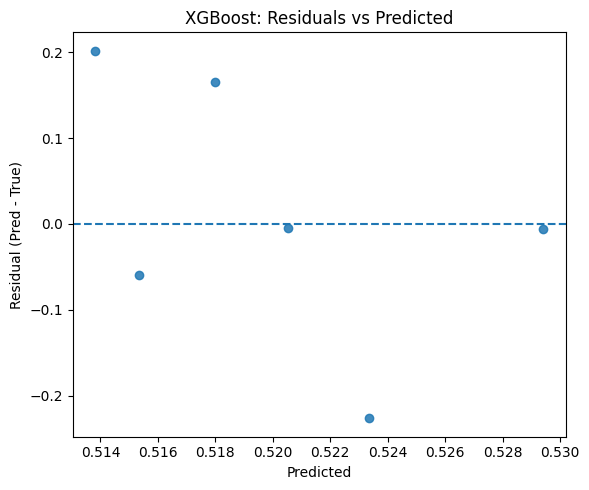

In [24]:
# Predictions vs Truth and residuals
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred, alpha=0.85)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, linestyle="--")
plt.xlabel("True xG+xAG per90 (next season)")
plt.ylabel("Predicted xG+xAG per90")
plt.title("XGBoost: Predictions vs Truth")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
res = y_pred - y_test
plt.scatter(y_pred, res, alpha=0.85)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residual (Pred - True)")
plt.title("XGBoost: Residuals vs Predicted")
plt.tight_layout()
plt.show()

**Interpretation**:
- The tuned XGBoost model performs similarly to the Random Forest and worse than the Linear Regression baseline (R² ≈ 0.03 vs. 0.27).
- This indicates that nonlinear structure is limited in the small dataset, and regularized linear relationships may already capture most of the signal.
- The model likely suffers from low data volume, narrow variance in target values, and potential noise in player-level data.

**Takeaway**:
- Unlike the linear and forest models that emphasized xG/xAG, XGBoost highlighted progressive actions and team strength — metrics describing how players generate opportunities rather than purely finishing output.
- This suggests the algorithm is leveraging contextual and creative contributions rather than direct goal metrics.

- Predictions vs. Truth: Points cluster tightly, showing underfitting (narrow prediction range).
- Residuals vs. Predicted: Mostly centered around zero, but low variance — the model doesn’t fully capture variation in top performers.
- Feature importance confirms that progressive play style and environment are strong leading indicators.

**Summary**
- XGBoost achieves comparable errors to Random Forest but doesn’t improve generalization (R² ≈ 0).
- Still useful for understanding nonlinear feature relationships and player development dynamics.
- The model’s emphasis on progressive actions + team context is consistent with tactical theory — creative volume and environment drive expected goal contribution growth.

### 25/26 predictions 

In [30]:
# --- Select the columns from your 2024/25 dataset ---
base_cols = [
    "player_key_or_id", 
    "Player",
    "xg_per90", "xag_per90", "Playing Time_Min", "ast_per90",
    "prgC_per90", "prgP_per90", "prgR_per90", "team_strength_curr"
]

# Create a new dataframe with only those columns
df_2425_t1 = df[base_cols].copy()

# --- Rename the performance features to *_t1 ---
rename_map = {
    "xg_per90": "xg_per90_t1",
    "xag_per90": "xag_per90_t1",
    "Playing Time_Min": "Playing Time_Min_t1",
    "ast_per90": "ast_per90_t1",
    "prgC_per90": "prgC_per90_t1",
    "prgP_per90": "prgP_per90_t1",
    "prgR_per90": "prgR_per90_t1",
    "team_strength_curr": "team_strength_t1"
}

df_2425_t1 = df_2425_t1.rename(columns=rename_map)

In [33]:
# Features in the SAME order used for training
predictor_features = [
    "xg_per90_t1",
    "xag_per90_t1",
    "ast_per90_t1",
    "prgC_per90_t1",
    "prgP_per90_t1",
    "prgR_per90_t1",
    "team_strength_t1",
    "Playing Time_Min_t1",
]

# input matrix
X_future = df_2425_t1[predictor_features].copy()

# Predict with fitted pipeline (Scaler + LinearRegression)
preds = linreg.predict(X_future)

# --- 4) Attach predictions to player identifiers ---
pred_2526 = df_2425_t1[["player_key_or_id", "Player"]].copy()
pred_2526["pred_xg_xag_per90_25_26"] = preds
pred_2526 = pred_2526.sort_values("pred_xg_xag_per90_25_26", ascending=False)
display(pred_2526.head(23))

,player_key_or_id,Player,pred_xg_xag_per90_25_26
19,e342ad68,Mohamed Salah,0.752218
3,2f9e4435,Dango Ouattara,0.651930
15,bc7dc64d,Bukayo Saka,0.637369
0,0cd31129,Brennan Johnson,0.576921
16,bf34eebd,Noni Madueke,0.566686
5,3ea50f67,Harvey Barnes,0.550760
11,7aa8adfe,Alejandro Garnacho,0.548279
20,ed1e53f3,Phil Foden,0.535050
17,c6dc9ecd,Harry Wilson,0.534228
1,1971591f,Cody Gakpo,0.520100


In [32]:
import plotly.express as px

fig = px.bar(
    pred_2526.sort_values("pred_xg_xag_per90_25_26", ascending=True),
    x="pred_xg_xag_per90_25_26",
    y="Player",
    orientation="h",
    title="Predicted xG+xAG per90 for 2025/26 Season (All 22 Players)",
    labels={"pred_xg_xag_per90_25_26": "Predicted xG+xAG per90"},
    text_auto=".2f"
)

fig.update_layout(
    xaxis_title="Predicted xG+xAG per90 (2025/26)",
    yaxis_title="Player",
    template="plotly_white",
    height=700
)

fig.show()


## Predicted xG+xAG per90 — 2025/26 Season (Linear Regression)

Using the Linear Regression model trained on 2023/24 → 2024/25 transitions, the 2024/25 season metrics were input to project each winger’s **expected goal + assist output per 90 minutes** for the 2025/26 Premier League season.

| Rank | Player | Predicted xG+xAG per90 (25/26) |
|:--:|:----------------|:----------------:|
| 1️⃣ | **Mohamed Salah** | **0.75** |
| 2️⃣ | **Dango Ouattara** | **0.65** |
| 3️⃣ | **Bukayo Saka** | **0.64** |
| 4️⃣ | **Brennan Johnson** | 0.58 |
| 5️⃣ | **Noni Madueke** | 0.57 |
| … | *(remaining 17 players range 0.55 → 0.31)* |  |

### 🔍 Interpretation

- **Dango Ouattara** is the **stand-out surprise** in these projections, ranking second overall behind only Mohamed Salah.  
  His underlying 2024/25 metrics — notably strong *progressive carries and passes* — drive a higher-than-expected predicted contribution, suggesting a strong foundation for attacking growth in 2025/26.
- **Elite consistency** is reflected in top performers such as Salah and Saka, whose balanced xG and xAG profiles maintain them near the top.
- The middle tier (Johnson, Madueke, Barnes, Garnacho, Foden) represents players with **solid creation and progression numbers** who project steady improvement.
- Lower-ranked outputs (e.g., Alex Iwobi, Pedro Neto) correspond to profiles with either reduced shooting volume or lower team strength scores.

The overall prediction spread (≈ 0.31 – 0.75 xG+xAG per90) remains moderate, consistent with the model’s linear nature and the relatively compact performance distribution among Premier League wingers.


The Linear Regression model balances interpretability with signal — identifying Ouattara and Madueke as high-upside profiles before their high-profile transfers.

Dango Ouattara being Brentford's club record signing with high upside is very interesting considering how heavily Brentford use data to make key decisions. Noni Madueke was also a surprise signing for Arsenal, could lead to underlining metric showing upside given the right enviorment.

## Future Work

While the current model offers a solid proof of concept for predicting next-season attacking output, several extensions could strengthen both accuracy and interpretability:

**Richer Datasets:**  
   Expanding beyond standard FBref metrics to include **StatsBomb event-level data**, tracking data, or **expected possession value (EPV)** models would capture spatial and contextual elements (e.g., shot quality, pressure, carry origin zones) that linear features miss.

### Summary
This analysis demonstrates how even a transparent **Linear Regression model** can provide meaningful insights into player development and recruitment.  
Future work will focus on scaling the framework with more sophisticated datasets, model ensembles, and interpretable analytics to create a **dynamic, data-driven forecasting system** for player performance in elite football.


In [34]:
# --- Select the features for prediction ---
X_future = df_2425_t1[predictor_features]

# --- Generate predictions using your trained Random Forest ---
rf_predictions = best_rf.predict(X_future)

# Ensure no negatives (xG+xAG can't be negative)
rf_predictions = np.clip(rf_predictions, 0, None)

# --- Combine predictions back with player info ---
pred_rf_2526 = df_2425_t1[["player_key_or_id", "Player"]].copy()
pred_rf_2526["pred_xg_xag_per90_25_26_rf"] = rf_predictions

# Preview results
pred_rf_2526.sort_values("pred_xg_xag_per90_25_26_rf", ascending=False).head(23)


,player_key_or_id,Player,pred_xg_xag_per90_25_26_rf
19,e342ad68,Mohamed Salah,0.692427
17,c6dc9ecd,Harry Wilson,0.544919
15,bc7dc64d,Bukayo Saka,0.542022
20,ed1e53f3,Phil Foden,0.530452
14,b0b4fd3e,Jack Grealish,0.522387
8,6ca5ec4b,Alex Iwobi,0.509202
0,0cd31129,Brennan Johnson,0.505585
18,de112b84,Jacob Murphy,0.502557
5,3ea50f67,Harvey Barnes,0.497448
1,1971591f,Cody Gakpo,0.496635


In [35]:
import plotly.express as px

fig = px.bar(
    pred_rf_2526.sort_values("pred_xg_xag_per90_25_26_rf", ascending=True),
    x="pred_xg_xag_per90_25_26_rf",
    y="Player",
    orientation="h",
    title="Predicted xG+xAG per90 — 2025/26 (Random Forest)",
    labels={"pred_xg_xag_per90_25_26_rf": "Predicted xG+xAG per90"},
    text_auto=".2f"
)

fig.update_layout(
    xaxis_title="Predicted xG+xAG per90 (2025/26)",
    yaxis_title="Player",
    template="plotly_white",
    height=700
)
fig.show()
